In [70]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import os, sys

In [71]:
# upload a dataset 

file_path = os.path.join(sys.path[0], "dialogues_v3_Evgeny.xlsx")
file_path_Evgeny = os.path.join(sys.path[0], "dialogues_v3_Evgeny.xlsx")
file_path_Tijs = os.path.join(sys.path[0], "dialogues_v3_Tijs.xlsx")

col_names = ['id', 'pagetitle', 'orig_user', 'reply_user', 'orig', 'reply',
       'disagreement', 'orig_id', 'reply_id', 'orig_toxicity',
       'orig_severe_toxicity', 'reply_toxicity', 'reply_severe_toxicity',
       'conv_id', 'COP', 'COP_flag', 'COP_why', 'FCG', 'FCG_flag',
       'FCG_why', 'RT', 'RT_flag', 'RT_why', 'PS',
       'PS_flag', 'PS_why', 'Overall comment', 'escalated']

csv_parameters = {
        'header' : 1, 
        'names' : col_names, 
        'index_col' :'id', 
        'convert_float' : True}

df_Evgeny = pd.read_excel(file_path_Evgeny, **csv_parameters)
df_Tijs = pd.read_excel(file_path_Tijs, **csv_parameters)

df = pd.concat([df_Evgeny, df_Tijs])

df = df.convert_dtypes()

# choose appropriate columns. drop lines without disagreement.
df_ess = df[['orig', 'reply', 'COP', 'FCG', 'RT', 'PS']].dropna()
labels = ['COP', 'FCG', 'RT', 'PS']

In [72]:
# choose appropriate columns. drop lines without disagreement.
df_ess = df[['orig', 'reply', 'COP', 'FCG', 'RT', 'PS', 'escalated']].dropna()
labels = ['COP', 'FCG', 'RT', 'PS']

## Discovery statistics

In [73]:
# data example
df_ess.sample(10)

,orig,reply,COP,FCG,RT,PS,escalated
id,,,,,,,
586,Criticism section\nThe section criticizing the...,Metropolis is a reliable source with a long hi...,1,0,1,1,0
2572,Scholarly contributions\nTo achieving NPOV is...,"Well, I'm permanently objecting to this materi...",1,0,1,0,0
1552,"For the official language thing check, Talk:Ic...",PS: I had already read the discussion you refe...,1,0,1,0,0
957,Disputed? \nI don't think that because a term...,"""please remove it and state that cannabis temp...",1,0,0,0,0
720,No discussion of when it happened and rather i...,What are you talking about? This article make...,1,0,0,1,0
1667,Exchange rate \nThe exchange rate table is ha...,The exchange rate was compiled from Malaysia: ...,0,0,1,1,0
2360,"Hello, Eddie. By coincidence, there was anothe...","Comment on the content, not the editor, pal.",0,0,1,0,0
548,There is no point in protecting the article. ...,"SLR, you can't ""compromise"" NPOV/NOR/V itself.",1,0,1,0,0
777,Classification of any incident as terrorism is...,Review NPOV - it's the general view of the top...,1,1,1,0,0


In [74]:
df_ess.escalated.value_counts()

0    1412
1     263
Name: escalated, dtype: Int64

In [75]:
# make sure there are no null values
df_ess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1675 entries, 1548 to 19656
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   orig       1675 non-null   object
 1   reply      1675 non-null   string
 2   COP        1675 non-null   Int64 
 3   FCG        1675 non-null   Int64 
 4   RT         1675 non-null   Int64 
 5   PS         1675 non-null   Int64 
 6   escalated  1675 non-null   Int64 
dtypes: Int64(5), object(1), string(1)
memory usage: 112.9+ KB


In [76]:
# look at the balance of lables in classes
for label in labels:
    print(df_ess[label].value_counts(normalize = True).sort_index(), '\n')
    
    

0    0.146269
1    0.853731
Name: COP, dtype: float64 

0    0.748657
1    0.251343
Name: FCG, dtype: float64 

0    0.208358
1    0.791045
2    0.000597
Name: RT, dtype: float64 

0    0.619701
1    0.380299
Name: PS, dtype: float64 



 # Split sets by train+dev and test

In [17]:
from sklearn.model_selection import train_test_split
# Test and train data split
df_train, df_test = train_test_split(df_ess, random_state = 42)

# Logistic regression

In [18]:
from better_profanity import profanity
import time
from progressbar import progressbar as pb
import re
from nltk import word_tokenize          


### Tokenizing

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.stem.snowball import EnglishStemmer
sw = stopwords.words("english")

# Create global vocab, unigrams
converter_reply = CountVectorizer(token_pattern=r"(?u)\b\w\w+\b|!|\?", stop_words = 'english')
all_words = df_ess['reply'].copy()


# reply 
reply = df_ess['reply'].copy()

# text pre-processing:
# Substitute all numbers in text with the <num> token
for i, text in reply.iteritems():
    res = re.sub('\d{1,100}', '<num>', text)
    reply[i] = res
df_ess['reply'] = reply
# Unigrams
# get global vocab for test, training and dev datasets (covers all data)
global_mat = converter_reply.fit_transform(df_ess['reply'])
vocab = converter_reply.vocabulary_
# CountVectorize
analyzer = CountVectorizer().build_analyzer()

# apply a stemmer
stemmer = EnglishStemmer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))




In [20]:
vocab

{'true': 10272,
 'problem': 7716,
 'article': 667,
 'written': 11015,
 'advocacy': 222,
 'linguistic': 5806,
 'purism': 7900,
 'description': 2707,
 'phenomenon': 7319,
 'fact': 3693,
 'heading': 4530,
 'preservation': 7642,
 'icelandic': 4803,
 'official': 6887,
 'language': 5624,
 'ideology': 4823,
 'terminology': 9931,
 'moved': 6464,
 'present': 7634,
 'changed': 1586,
 'word': 10973,
 'phrases': 7337,
 'maintain': 5968,
 'purity': 7902,
 'used': 10538,
 'time': 10079,
 'just': 5447,
 'literally': 5826,
 'making': 5981,
 'new': 6663,
 'words': 10977,
 'things': 10019,
 'inexistent': 5033,
 'old': 6905,
 'norse': 6737,
 'replace': 8343,
 'loanwords': 5848,
 'means': 6136,
 'repeating': 8335,
 'arguments': 627,
 'pamphlet': 7087,
 'government': 4320,
 'ancient': 435,
 'modern': 6381,
 'emotionally': 3322,
 'laden': 5606,
 'subject': 9572,
 'don': 3048,
 'think': 10020,
 'like': 5787,
 'thought': 10035,
 'weasel': 10826,
 'context': 2173,
 'concept': 2003,
 'definitions': 2618,
 'vary

In [44]:
scores_dic = {}
scores = ['F1', 'Precision', 'Recall']
for s in scores:
    scores_dic[s] = {}
scores_dic['F1']['blah'] = []
scores_dic['F1']['blah']
scores_dic

{'F1': {'blah': []}, 'Precision': {}, 'Recall': {}}

### Train and evaluate model on dev sets via Kfolding

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay 
import seaborn as sns
import matplotlib.pyplot as plt



def train_and_test(df_train, vec_params, model):
    X = df_train['reply']
    # Define dictionaries with future scores and confusion matrix values
    scores_dic = {}
    con_mat_dic = {}
    coeff_dic = {}
    intercept_dic = {}
    scores = ['F1', 'Precision', 'Recall']
    
    for s in scores:
        scores_dic[s] = {}
    
    for l in labels:
        scores_dic['F1'][l] = []
        scores_dic['Precision'][l] = []
        scores_dic['Recall'][l] = []
        con_mat_dic[l] = []
        coeff_dic[l] = []
        intercept_dic[l] = []
    scores = []
    # Define Kfolding algorithm
    kf =  KFold(random_state=42, shuffle=True, n_splits = 5)
    # Initiate iteratable splits 
    splits = kf.split(df_train)
    # Iterate over each fold
    for train_index, dev_index in pb(splits):
        X_train, X_dev = X.iloc[train_index], X.iloc[dev_index]
        # iterate over each label
        for l in labels:
            y = df_train[l]
            y = y.astype('int')
            y_train, y_dev = y.iloc[train_index], y.iloc[dev_index]            
            # define vectorizer parameters
            params = vec_params
            # apply vectorizer
            bow_converter_reply = CountVectorizer(**params)
            X_train_vec = bow_converter_reply.fit_transform(X_train)
            X_dev_vec = bow_converter_reply.fit_transform(X_dev)
            # choose a model
            model = model.fit(X_train_vec, y_train)
            # make a prediction
            y_pred = model.predict(X_dev_vec)
            # Compute scores
            precision, recall, f1, _ = precision_recall_fscore_support(y_dev, y_pred, average = 'macro')
            scores_dic['F1'][l].append(f1)
            scores_dic['Precision'][l].append(precision)
            scores_dic['Recall'][l].append(recall)
            # confusion matrix
            con_mat = confusion_matrix(y_dev, y_pred, normalize = 'true', labels = [0,1])
            con_mat_dic[l].append(con_mat)
            # Compute coefficients
            coeff_dic[l].append(model.coef_)
            intercept_dic[l].append(model.intercept_)
            all_dics = {'scores_dic':scores_dic, 
                            'con_mat_dic':con_mat_dic,
                            'coeff_dic':coeff_dic,
                           'intercept_dic':intercept_dic}
    return all_dics

    
        

def visualize_scores(scores_dic, graph = True, save = False):
    # Show aggregated f1 scores for each category, averaging all folds
    # Parameters:
    # save (str) - write a name of the png image you want to save
    data = pd.DataFrame(scores_dic['F1'])
    ax = sns.catplot(data=data, ci = 'sd', kind = 'bar')
    n_folds = len(scores_dic['F1']['FCG'])
    ax.set(xlabel='Categories', ylabel='F1 scores', title=f'F1 scores results after {n_folds} folds')
    if graph == True:
        plt.show()
    else:
        plt.clf()
    means = []
    sds = []
    for key in scores_dic['F1'].keys():
        f1_scores = scores_dic['F1'][key]
        precision_scores = scores_dic['Precision'][key]
        recall_scores = scores_dic['Recall'][key]
        f1_m = np.mean(f1_scores)
        f1_sd = np.std(f1_scores)
        
        precision_m = np.mean(precision_scores)
        precision_sd = np.std(precision_scores)
        
        recall_m = np.mean(recall_scores)
        recall_sd = np.std(recall_scores)


        print(f'{key}:\n\
              F1 = {f1_m:.2}, SD = {f1_sd:.2}\n\
              Recall = {recall_m:.2}, SD = {recall_sd:.2}\n\
              Precision = {precision_m:.2}, SD = {precision_sd:.2}')
        means.append(f1_m)
        sds.append(f1_sd)
    print(f'Average scores: mean = {np.mean(means):.2}, sd = {np.mean(sds):.2}')
    if save:
        plt.savefig(save)


def visualize_conf_matrix(con_mat_dic):
    # Show confusion matrix for aggrigated folding scores for each label
    conf_mat_vis_dic = {}
    for key in con_mat_dic.keys():
        # assign list of confusion matricies to a variable ls
        ls = con_mat_dic[key]
        # aggrigated confusion matrix for all folds
        cm = sum(ls)/len(ls)
        # create a chart
        cmd = ConfusionMatrixDisplay(cm, display_labels = [0,1])
        conf_mat_vis_dic[key] = cmd
    # plot chart
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30,5))
    counter = 0
    for key, val in conf_mat_vis_dic.items():
        val.plot(ax = axes[counter])
        axes[counter].set_title(key)
        counter+=1
    plt.show()


def print_top_n(vectorizer, clf, class_labels, label, n):
# Prints features with the highest coefficient values, per class
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        absValues = [abs(number) for number in clf[0]]
        top_n = np.flipud(np.argsort(absValues)[-n:])
        vals_and_words = list(zip(clf[0][top_n], [feature_names[j] for j in top_n]))
        # Print a pair of a feature (word) and its weight for each label
        print(f'\n{label}')
        for pair in vals_and_words:
            print(f'{pair[1]:.<15}{pair[0]:.3f}')

def show_coefficients(coeff_dic, converter, top_number = 15):
    print(f'Top {top_number} features for each category:')
    denum = len(coeff_dic['COP'])
    for key, val in coeff_dic.items():
        final = np.sum(val, axis = 0)/denum
        print_top_n(converter, final, [0], label = key, n = top_number)
      
    




/ |#                                                  | 0 Elapsed Time: 0:00:00


REGULAZRIZATION PARAMETER IS 0.0001


| |                          #                        | 4 Elapsed Time: 0:00:02


COP:
              F1 = 0.53, SD = 0.044
              Recall = 0.67, SD = 0.053
              Precision = 0.59, SD = 0.029
FCG:
              F1 = 0.7, SD = 0.056
              Recall = 0.7, SD = 0.056
              Precision = 0.7, SD = 0.057
RT:
              F1 = 0.56, SD = 0.062
              Recall = 0.61, SD = 0.05
              Precision = 0.58, SD = 0.039
PS:
              F1 = 0.65, SD = 0.03
              Recall = 0.65, SD = 0.027
              Precision = 0.68, SD = 0.021
Average scores: mean = 0.61, sd = 0.048


<Figure size 360x360 with 0 Axes>

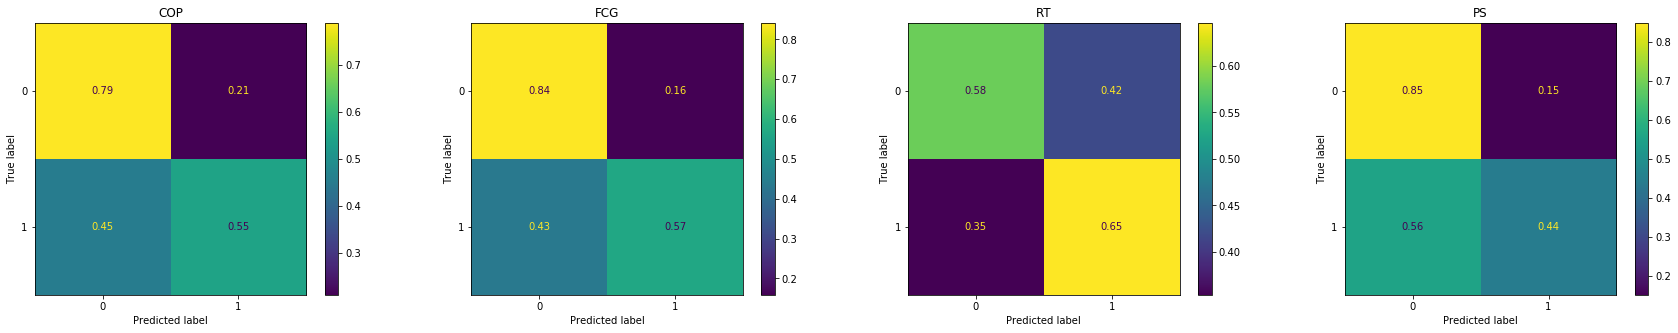

/ |#                                                  | 0 Elapsed Time: 0:00:00


REGULAZRIZATION PARAMETER IS 0.001


| |                          #                        | 4 Elapsed Time: 0:00:02


COP:
              F1 = 0.54, SD = 0.042
              Recall = 0.67, SD = 0.053
              Precision = 0.59, SD = 0.029
FCG:
              F1 = 0.72, SD = 0.048
              Recall = 0.72, SD = 0.047
              Precision = 0.72, SD = 0.048
RT:
              F1 = 0.57, SD = 0.049
              Recall = 0.62, SD = 0.035
              Precision = 0.58, SD = 0.03
PS:
              F1 = 0.66, SD = 0.025
              Recall = 0.66, SD = 0.024
              Precision = 0.69, SD = 0.013
Average scores: mean = 0.62, sd = 0.041


<Figure size 360x360 with 0 Axes>

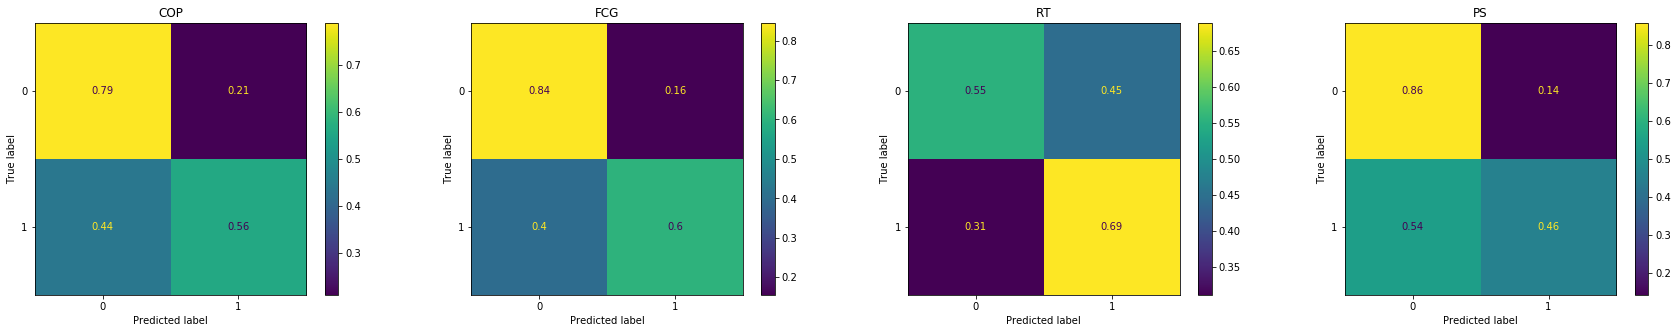

/ |#                                                  | 0 Elapsed Time: 0:00:00


REGULAZRIZATION PARAMETER IS 0.01


| |                           #                       | 4 Elapsed Time: 0:00:02


COP:
              F1 = 0.58, SD = 0.021
              Recall = 0.69, SD = 0.028
              Precision = 0.6, SD = 0.015
FCG:
              F1 = 0.72, SD = 0.037
              Recall = 0.73, SD = 0.038
              Precision = 0.72, SD = 0.036
RT:
              F1 = 0.63, SD = 0.031
              Recall = 0.66, SD = 0.025
              Precision = 0.63, SD = 0.028
PS:
              F1 = 0.69, SD = 0.033
              Recall = 0.69, SD = 0.034
              Precision = 0.72, SD = 0.02
Average scores: mean = 0.66, sd = 0.03


<Figure size 360x360 with 0 Axes>

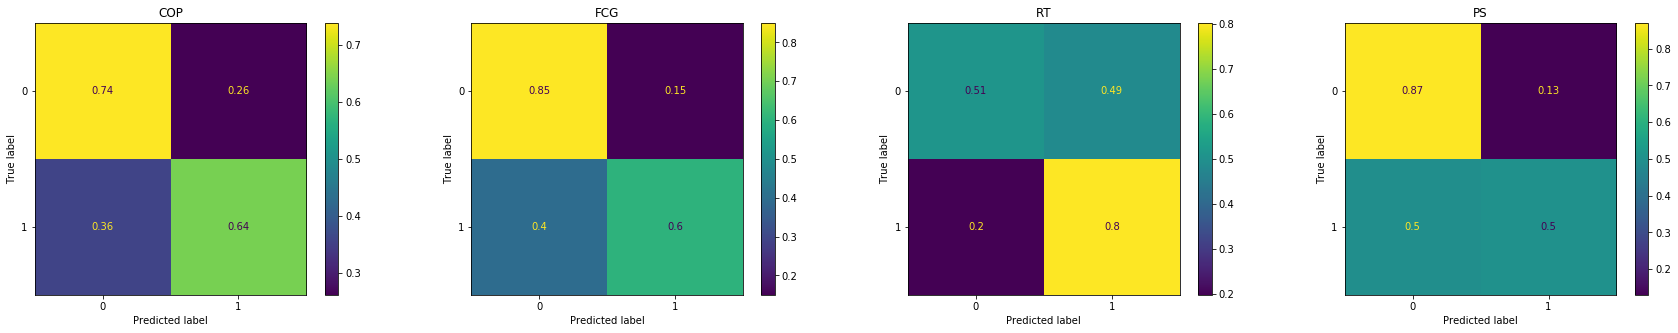

/ |#                                                  | 0 Elapsed Time: 0:00:00


REGULAZRIZATION PARAMETER IS 0.1


| |                               #                   | 4 Elapsed Time: 0:00:03


COP:
              F1 = 0.62, SD = 0.026
              Recall = 0.68, SD = 0.029
              Precision = 0.61, SD = 0.02
FCG:
              F1 = 0.7, SD = 0.042
              Recall = 0.7, SD = 0.043
              Precision = 0.7, SD = 0.041
RT:
              F1 = 0.63, SD = 0.035
              Recall = 0.63, SD = 0.033
              Precision = 0.63, SD = 0.038
PS:
              F1 = 0.69, SD = 0.032
              Recall = 0.68, SD = 0.033
              Precision = 0.72, SD = 0.025
Average scores: mean = 0.66, sd = 0.034


<Figure size 360x360 with 0 Axes>

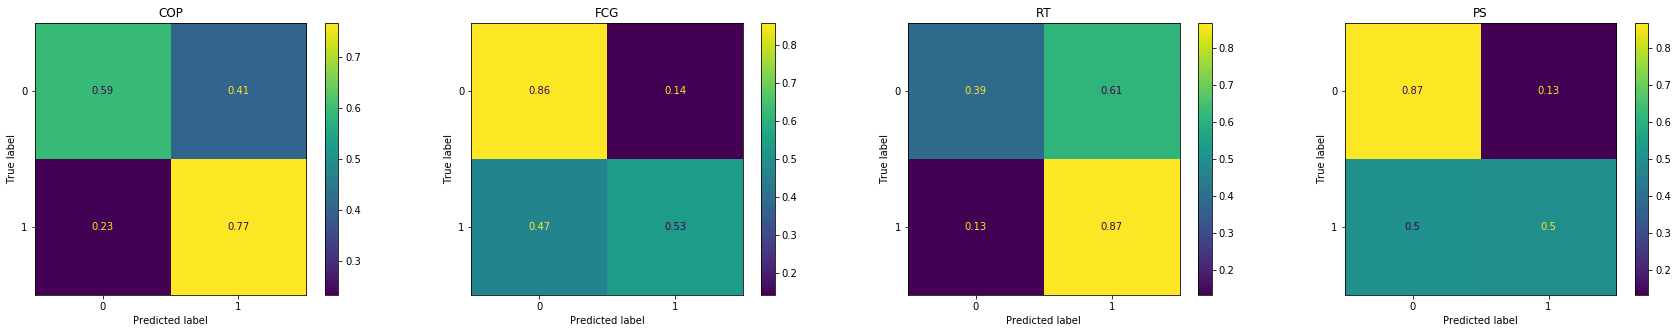

/ |#                                                  | 0 Elapsed Time: 0:00:00


REGULAZRIZATION PARAMETER IS 1


| |                                         #         | 4 Elapsed Time: 0:00:04


COP:
              F1 = 0.63, SD = 0.032
              Recall = 0.65, SD = 0.04
              Precision = 0.62, SD = 0.028
FCG:
              F1 = 0.66, SD = 0.037
              Recall = 0.65, SD = 0.038
              Precision = 0.67, SD = 0.032
RT:
              F1 = 0.61, SD = 0.055
              Recall = 0.6, SD = 0.053
              Precision = 0.62, SD = 0.059
PS:
              F1 = 0.68, SD = 0.036
              Recall = 0.68, SD = 0.035
              Precision = 0.71, SD = 0.028
Average scores: mean = 0.64, sd = 0.04


<Figure size 360x360 with 0 Axes>

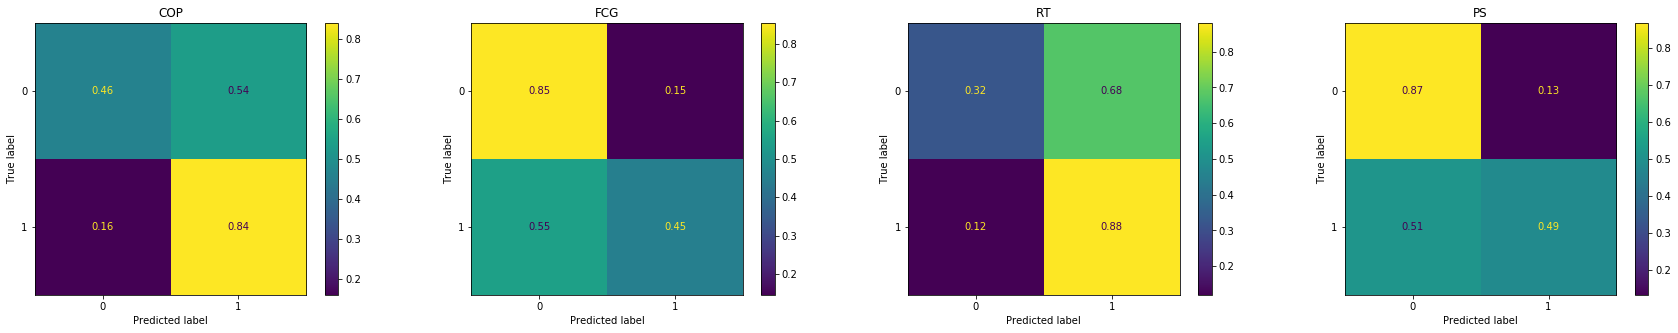

/ |#                                                  | 0 Elapsed Time: 0:00:00


REGULAZRIZATION PARAMETER IS 10


| |                                               #   | 4 Elapsed Time: 0:00:04


COP:
              F1 = 0.61, SD = 0.049
              Recall = 0.62, SD = 0.058
              Precision = 0.6, SD = 0.044
FCG:
              F1 = 0.65, SD = 0.039
              Recall = 0.64, SD = 0.04
              Precision = 0.65, SD = 0.036
RT:
              F1 = 0.59, SD = 0.05
              Recall = 0.59, SD = 0.048
              Precision = 0.6, SD = 0.053
PS:
              F1 = 0.67, SD = 0.034
              Recall = 0.66, SD = 0.032
              Precision = 0.7, SD = 0.028
Average scores: mean = 0.63, sd = 0.043


<Figure size 360x360 with 0 Axes>

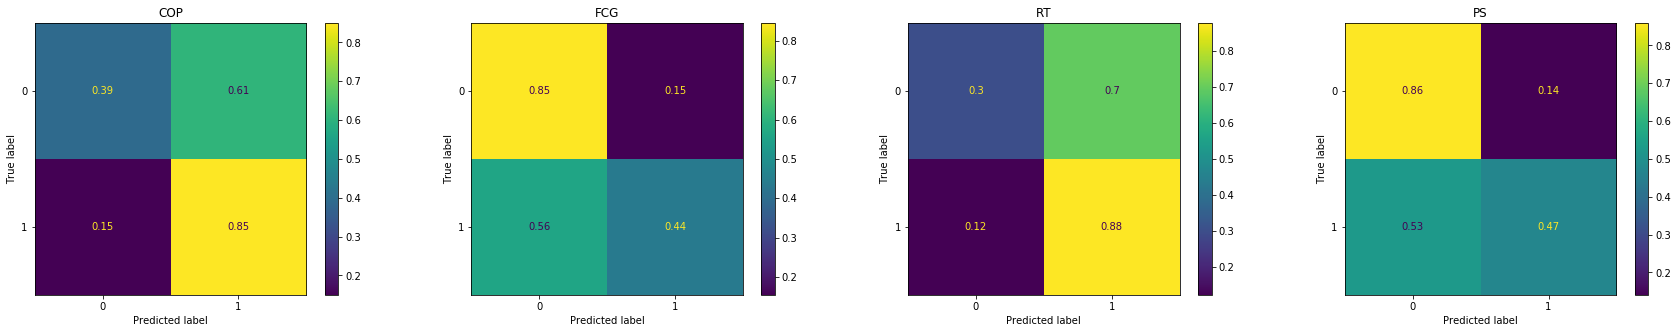

/ |#                                                  | 0 Elapsed Time: 0:00:00


REGULAZRIZATION PARAMETER IS 100


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
\ |                  #                                | 2 Elapsed Time: 0:00:01/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alter

COP:
              F1 = 0.6, SD = 0.042
              Recall = 0.61, SD = 0.051
              Precision = 0.59, SD = 0.039
FCG:
              F1 = 0.65, SD = 0.04
              Recall = 0.64, SD = 0.04
              Precision = 0.65, SD = 0.039
RT:
              F1 = 0.59, SD = 0.04
              Recall = 0.58, SD = 0.038
              Precision = 0.6, SD = 0.044
PS:
              F1 = 0.66, SD = 0.032
              Recall = 0.66, SD = 0.029
              Precision = 0.69, SD = 0.024
Average scores: mean = 0.62, sd = 0.039


<Figure size 360x360 with 0 Axes>

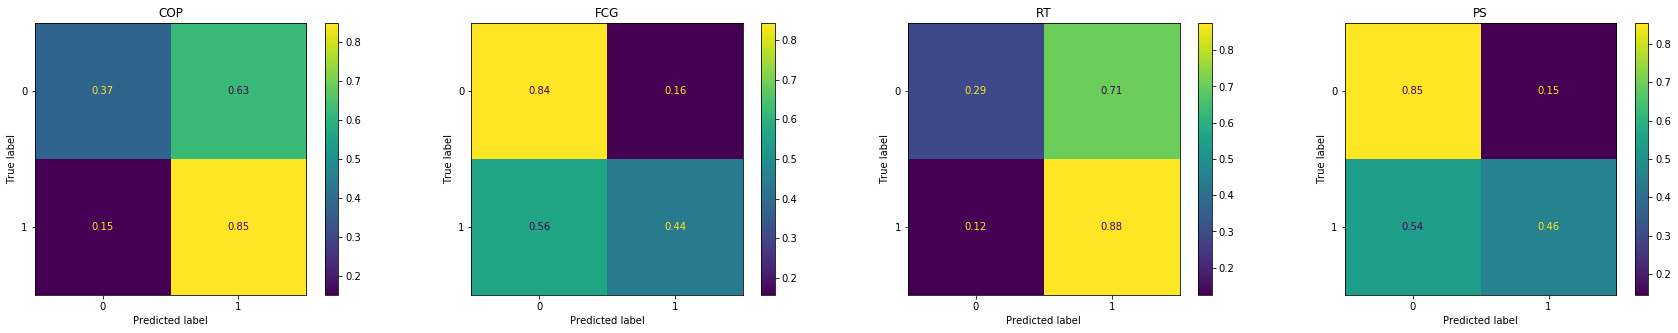

In [65]:
# CountVectorizer
# Try different learning rates
reg_par = [.0001, .001, .01, .1, 1, 10, 100]
for rp in reg_par:
    model = LogisticRegression(C=rp, class_weight = 'balanced')
    params = {'token_pattern': r"(?u)\b\w\w+\b|!|\?|<num>", 
              'stop_words': sw, 
              'vocabulary': vocab}
    print(f'\nREGULAZRIZATION PARAMETER IS {rp}')
    count_vec_dics = train_and_test(df_train, vec_params = params, model = model)
    visualize_scores(count_vec_dics['scores_dic'], graph = False)
    visualize_conf_matrix(count_vec_dics['con_mat_dic'])
    

Regularization parameter c equal to .1 seems optimal. 

| |                               #                   | 4 Elapsed Time: 0:00:03


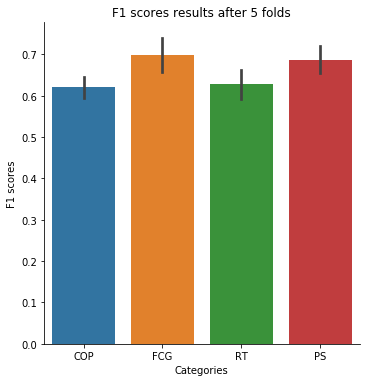

COP:
              F1 = 0.62, SD = 0.026
              Recall = 0.68, SD = 0.029
              Precision = 0.61, SD = 0.02
FCG:
              F1 = 0.7, SD = 0.042
              Recall = 0.7, SD = 0.043
              Precision = 0.7, SD = 0.041
RT:
              F1 = 0.63, SD = 0.035
              Recall = 0.63, SD = 0.033
              Precision = 0.63, SD = 0.038
PS:
              F1 = 0.69, SD = 0.032
              Recall = 0.68, SD = 0.033
              Precision = 0.72, SD = 0.025
Average scores: mean = 0.66, sd = 0.034


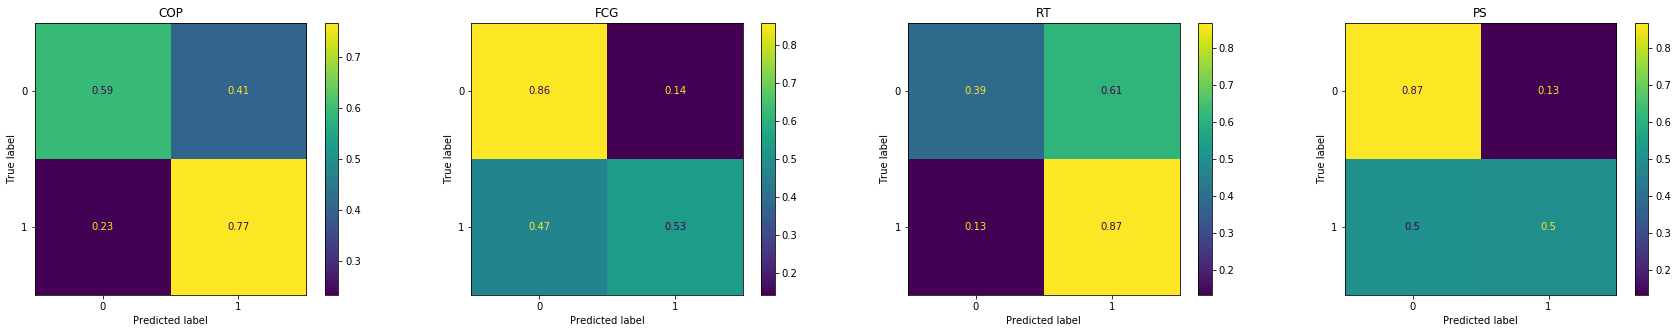

Top 15 features for each category:

COP
section........0.408
word...........0.400
source.........0.384
problem........0.353
say............0.328
mention........0.324
evidence.......0.322
?..............0.320
know...........0.309
use............0.309
claims.........0.309
mentioned......0.303
said...........0.296
certainly......0.295
look...........0.289

FCG
?..............1.177
wikipedia......-0.521
explain........0.444
feel...........0.353
partisan.......0.343
work...........0.327
!..............-0.321
dont...........0.283
better.........0.263
wp.............-0.261
states.........-0.257
criticism......0.253
fair...........0.246
historian......0.244
matter.........-0.243

RT
!..............-0.612
section........0.428
tag............0.407
stop...........-0.397
used...........0.368
issue..........0.328
fringe.........-0.327
work...........0.314
quote..........0.311
agree..........0.298
misleading.....-0.290
?..............-0.289
removing.......0.287
better.........0.282
wp.............-0

In [66]:
# CountVectorizer - final version of dev set + conf matrix + coefficients 
model = LogisticRegression(C=.1, class_weight = 'balanced')
params = {'token_pattern': r"(?u)\b\w\w+\b|!|\?|<num>", 
          'stop_words': sw, 
          'vocabulary': vocab}
converter = CountVectorizer(**params)
count_vec_dics = train_and_test(df_train, vec_params = params, model = model)
visualize_scores(count_vec_dics['scores_dic'])
visualize_conf_matrix(count_vec_dics['con_mat_dic'])
show_coefficients(count_vec_dics['coeff_dic'], converter = converter, top_number = 15)

In [67]:
# get the averaged coefficient 
averaged_coeff_dic = {}
averaged_intercept_dic={}
count_vec_dics['coeff_dic']
denum = len(count_vec_dics['coeff_dic']['COP'])
for label in labels:
    averaged_coeff_dic[label] =  np.sum(count_vec_dics['coeff_dic'][label], axis = 0)/denum
    averaged_intercept_dic[label] = np.sum(count_vec_dics['intercept_dic'][label], axis = 0)/denum
print(averaged_coeff_dic)
print(averaged_intercept_dic)

{'COP': array([[-0.27461051,  0.31954779,  0.        , ...,  0.0040465 ,
         0.0040465 ,  0.0040465 ]]), 'FCG': array([[-0.32065208,  1.17667624,  0.        , ..., -0.00399617,
        -0.00399617, -0.00399617]]), 'RT': array([[-0.61246816, -0.28926086,  0.        , ...,  0.00838766,
         0.00838766,  0.00838766]]), 'PS': array([[-0.14246145, -0.16466432,  0.        , ...,  0.00961034,
         0.00961034,  0.00961034]])}
{'COP': array([-0.62781923]), 'FCG': array([-0.96479679]), 'RT': array([0.17321444]), 'PS': array([-1.4512921])}


In [68]:
# Get scores for each label for the test data
model = LogisticRegression(C=.1, class_weight = 'balanced')
params = {'token_pattern': r"(?u)\b\w\w+\b|!|\?|<num>", 
          'stop_words': sw, 
          'vocabulary': vocab}
converter = CountVectorizer(**params)




scores_dic = {}
con_mat_dic = {}
coeff_dic = {}
scores = ['F1', 'Precision', 'Recall']
    
for s in scores:
    scores_dic[s] = {}

for l in labels:
    scores_dic['F1'][l] = []
    scores_dic['Precision'][l] = []
    scores_dic['Recall'][l] = []
    con_mat_dic[l] = []
    coeff_dic[l] = []


for label in labels:
    y_test = df_test[label]
    y_test = y_test.astype('int')
    # apply vectorizer
    X_test_vec = converter.fit_transform(df_test['reply'])
    model.coef_ = averaged_coeff_dic[label]
    model.intercept_ = averaged_intercept_dic[label]
    model.classes_ = np.array([0,1])
    # make a prediction
    y_pred = model.predict(X_test_vec)
    
    
    # Compute scores
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average = 'macro')
    scores_dic['F1'][label].append(f1)
    scores_dic['Precision'][label].append(precision)
    scores_dic['Recall'][label].append(recall)

    # confusion matrix
    con_mat = confusion_matrix(y_test, y_pred, normalize = 'true', labels = [0,1])
    con_mat_dic[label].append(con_mat)
    # Add coefficient dic
    coeff_dic[label].append(model.coef_)
    all_dics_test = {'scores_dic':scores_dic, 
                    'con_mat_dic':con_mat_dic,
                     'coeff_dic':coeff_dic
                    }
    

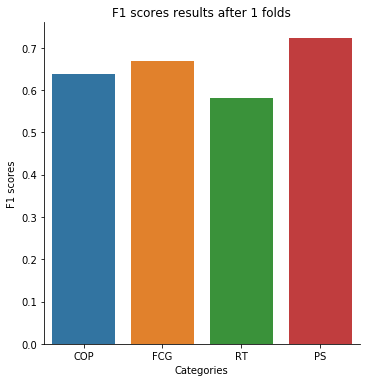

COP:
              F1 = 0.64, SD = 0.0
              Recall = 0.73, SD = 0.0
              Precision = 0.63, SD = 0.0
FCG:
              F1 = 0.67, SD = 0.0
              Recall = 0.67, SD = 0.0
              Precision = 0.67, SD = 0.0
RT:
              F1 = 0.58, SD = 0.0
              Recall = 0.58, SD = 0.0
              Precision = 0.59, SD = 0.0
PS:
              F1 = 0.72, SD = 0.0
              Recall = 0.72, SD = 0.0
              Precision = 0.76, SD = 0.0
Average scores: mean = 0.65, sd = 0.0


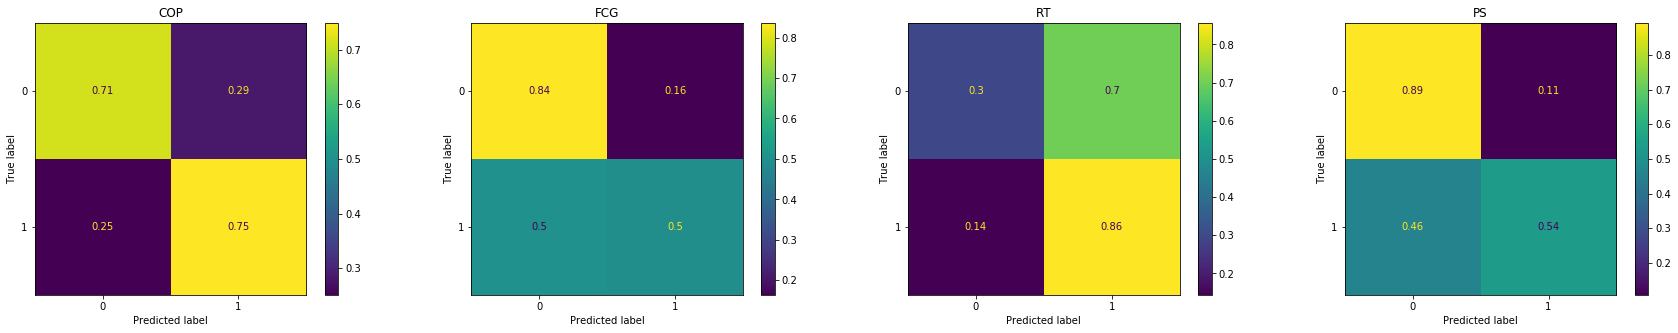

Top 15 features for each category:

COP
section........0.408
word...........0.400
source.........0.384
problem........0.353
say............0.328
mention........0.324
evidence.......0.322
?..............0.320
know...........0.309
use............0.309
claims.........0.309
mentioned......0.303
said...........0.296
certainly......0.295
look...........0.289

FCG
?..............1.177
wikipedia......-0.521
explain........0.444
feel...........0.353
partisan.......0.343
work...........0.327
!..............-0.321
dont...........0.283
better.........0.263
wp.............-0.261
states.........-0.257
criticism......0.253
fair...........0.246
historian......0.244
matter.........-0.243

RT
!..............-0.612
section........0.428
tag............0.407
stop...........-0.397
used...........0.368
issue..........0.328
fringe.........-0.327
work...........0.314
quote..........0.311
agree..........0.298
misleading.....-0.290
?..............-0.289
removing.......0.287
better.........0.282
wp.............-0

In [69]:
visualize_scores(all_dics_test['scores_dic'])
visualize_conf_matrix(all_dics_test['con_mat_dic'])
show_coefficients(all_dics_test['coeff_dic'], converter = converter, top_number = 15)